In [44]:
import pandas as pd
import numpy as np
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot, plot_forecast_component
from plotnine import *

# Data Loading

In [3]:
df=pd.read_csv('/home/ubuntu/code/prophet/examples/example_wp_log_peyton_manning.csv')
df.loc[:,'ds']=pd.to_datetime(df.ds,format='%Y-%m-%d')
print(df.shape)
print(df.ds.min(),df.ds.max())
df.head(5)

(2905, 2)
2007-12-10 00:00:00 2016-01-20 00:00:00


,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


# 01 Modeling Holidays and Special Events 

## 1.1 Create holiday df 

In [12]:
playoffs=pd.DataFrame({
    'holiday':'playoff',
    'ds':pd.to_datetime(['2008-01-13', '2009-01-03', '2010-01-16',
                         '2010-01-24', '2010-02-07', '2011-01-08',
                         '2013-01-12', '2014-01-12', '2014-01-19',
                         '2014-02-02', '2015-01-11', '2016-01-17',
                         '2016-01-24', '2016-02-07']),
    'lower_window':0,
    'upper_window':1,
})

superbowls=pd.DataFrame({
    'holiday':'superbowl',
    'ds':pd.to_datetime(['2010-02-07', '2014-02-02', '2016-02-07']),
    'lower_window':0,
    'upper_window':1
})
holiday=pd.concat([playoffs,superbowls])
print(holiday.shape)
holiday.head(5)

(17, 4)


,holiday,ds,lower_window,upper_window
0,playoff,2008-01-13,0,1
1,playoff,2009-01-03,0,1
2,playoff,2010-01-16,0,1
3,playoff,2010-01-24,0,1
4,playoff,2010-02-07,0,1


## 1.2 Fitting 

In [13]:
m=Prophet(holidays=holiday)
m.fit(df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [14]:
## Making future table
future=m.make_future_dataframe(periods=365)
future.tail(5)

,ds
3265,2017-01-15
3266,2017-01-16
3267,2017-01-17
3268,2017-01-18
3269,2017-01-19


## 1.3  Predicting

In [15]:
forecast=m.predict(future)
print(forecast.columns)
forecast.tail(5)

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'holidays', 'holidays_lower', 'holidays_upper', 'playoff',
       'playoff_lower', 'playoff_upper', 'superbowl', 'superbowl_lower',
       'superbowl_upper', 'weekly', 'weekly_lower', 'weekly_upper', 'yearly',
       'yearly_lower', 'yearly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
3265,2017-01-15,7.204061,7.293909,8.772231,6.890094,7.544851,0.832112,0.832112,0.832112,0.0,...,0.016553,0.016553,0.016553,0.815559,0.815559,0.815559,0.0,0.0,0.0,8.036173
3266,2017-01-16,7.203080,7.732401,9.065972,6.887772,7.545686,1.167681,1.167681,1.167681,0.0,...,0.329642,0.329642,0.329642,0.838039,0.838039,0.838039,0.0,0.0,0.0,8.370761
3267,2017-01-17,7.202099,7.474961,8.856119,6.885489,7.546568,0.993733,0.993733,0.993733,0.0,...,0.133009,0.133009,0.133009,0.860724,0.860724,0.860724,0.0,0.0,0.0,8.195832
3268,2017-01-18,7.201119,7.306801,8.717103,6.883205,7.547664,0.830127,0.830127,0.830127,0.0,...,-0.053235,-0.053235,-0.053235,0.883362,0.883362,0.883362,0.0,0.0,0.0,8.031246
3269,2017-01-19,7.200138,7.379605,8.772959,6.881139,7.548545,0.846427,0.846427,0.846427,0.0,...,-0.059214,-0.059214,-0.059214,0.905641,0.905641,0.905641,0.0,0.0,0.0,8.046565


### Reviewing 

In [16]:
## Review Impact
forecast.loc[abs(forecast.playoff+forecast.superbowl)>0,['ds','playoff','superbowl']][-10:]

,ds,playoff,superbowl
2190,2014-02-02,1.220720,1.214678
2191,2014-02-03,1.901618,1.460850
2532,2015-01-11,1.220720,0.000000
2533,2015-01-12,1.901618,0.000000
2901,2016-01-17,1.220720,0.000000
2902,2016-01-18,1.901618,0.000000
2908,2016-01-24,1.220720,0.000000
2909,2016-01-25,1.901618,0.000000
2922,2016-02-07,1.220720,1.214678
2923,2016-02-08,1.901618,1.460850


In [18]:
## All special holidays
# need to test whether any date would have impact -> June 22
forecast.loc[(forecast.ds.isin(holiday.ds))|
             (abs(forecast.playoff+forecast.superbowl)>0),['ds','playoff','superbowl']]

,ds,playoff,superbowl
34,2008-01-13,1.220720,0.000000
35,2008-01-14,1.901618,0.000000
361,2009-01-03,1.220720,0.000000
362,2009-01-04,1.901618,0.000000
730,2010-01-16,1.220720,0.000000
731,2010-01-17,1.901618,0.000000
737,2010-01-25,1.901618,0.000000
750,2010-02-07,1.220720,1.214678
1076,2011-01-08,1.220720,0.000000
1077,2011-01-09,1.901618,0.000000


### Viz - Trend & Change Points - With Holiday Impact 

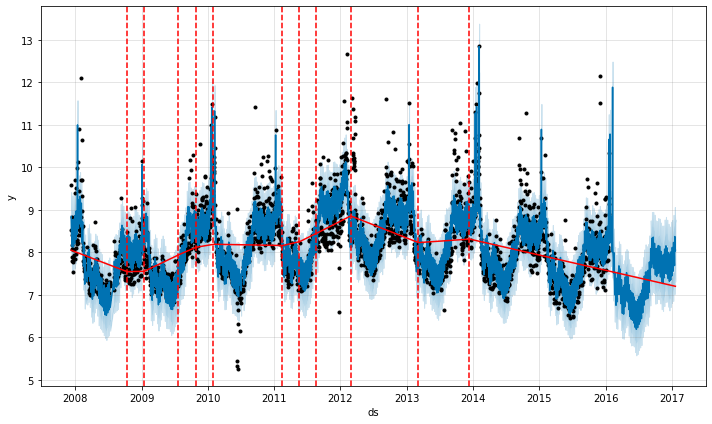

In [22]:
## Trend & change points
fig=m.plot(forecast)
a=add_changepoints_to_plot(fig.gca(),m,forecast) # only 11 change points, but 17/14 holiday inputs

In [23]:
holiday

,holiday,ds,lower_window,upper_window
0,playoff,2008-01-13,0,1
1,playoff,2009-01-03,0,1
2,playoff,2010-01-16,0,1
3,playoff,2010-01-24,0,1
4,playoff,2010-02-07,0,1
5,playoff,2011-01-08,0,1
6,playoff,2013-01-12,0,1
7,playoff,2014-01-12,0,1
8,playoff,2014-01-19,0,1
9,playoff,2014-02-02,0,1


### Viz - Components Plot 

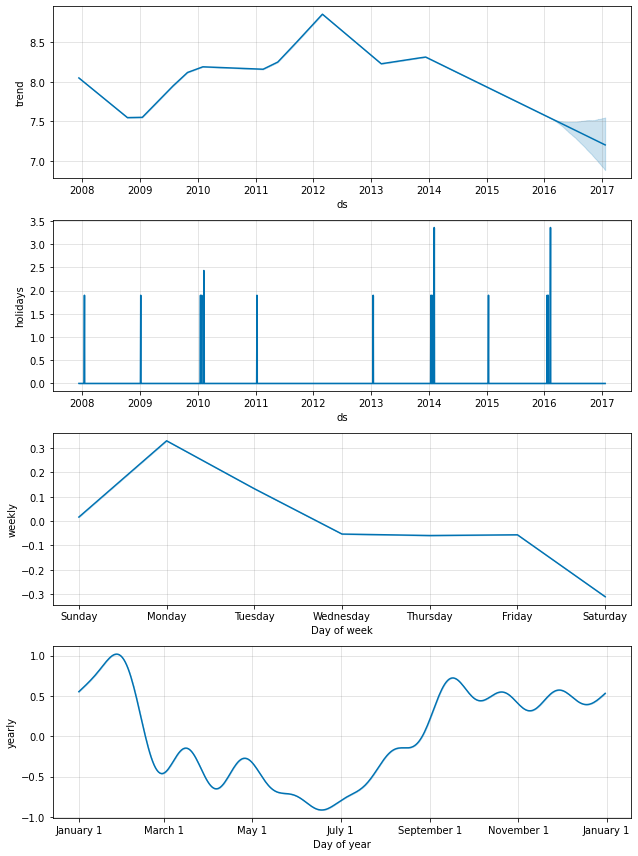

In [24]:
fig_com=m.plot_components(forecast)

### Viz - plot just holiday Components 

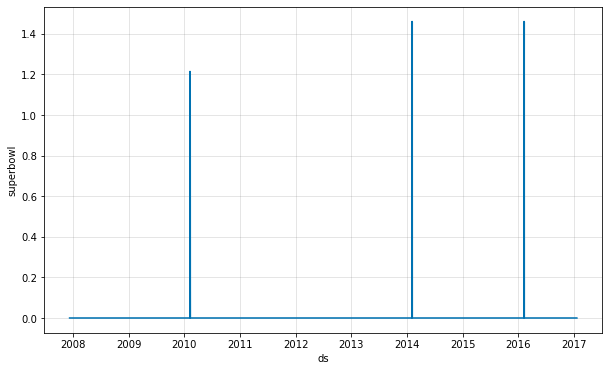

In [28]:
fig_fcom=plot_forecast_component(m,forecast,'superbowl')

## 1.4 All Holiday Effect 

### Reconfigure Holiday 

In [30]:
df

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572
...,...,...
2900,2016-01-16,7.817223
2901,2016-01-17,9.273878
2902,2016-01-18,10.333775
2903,2016-01-19,9.125871


In [33]:
holiday_all_effect=pd.DataFrame({
    'holiday':'holiday_all',
    'ds':df.ds,
    'lower_window':0,
    'upper_window':1
    })
super_all_effect=pd.DataFrame({
    'holiday':'super_all',
    'ds':df.ds,
    'lower_window':0,
    'upper_window':1
})
holiday_all=pd.concat([holiday_all_effect,super_all_effect])
print(holiday_all.shape)
holiday_all.head(5)

(5810, 4)


,holiday,ds,lower_window,upper_window
0,holiday_all,2007-12-10,0,1
1,holiday_all,2007-12-11,0,1
2,holiday_all,2007-12-12,0,1
3,holiday_all,2007-12-13,0,1
4,holiday_all,2007-12-14,0,1


### Modeling 

In [35]:
m_all_holiday=Prophet(holidays=holiday_all)
m_all_holiday.fit(df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### Prediction 

In [37]:
forecast_all_holiday=m_all_holiday.predict(future)

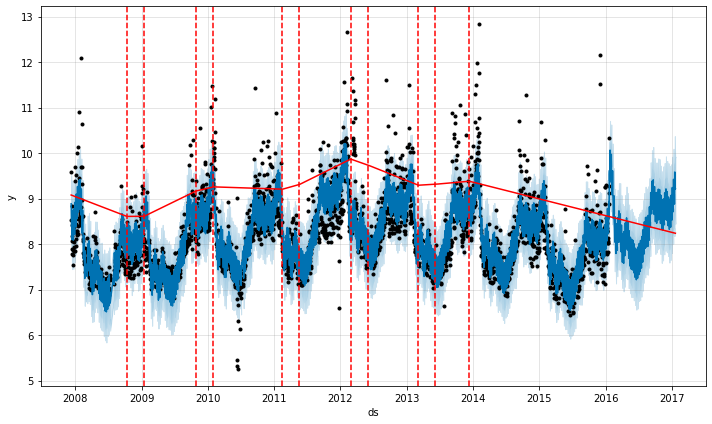

In [38]:
## Viz
fig_all_holiday=m_all_holiday.plot(forecast_all_holiday)
a_all_holiday=add_changepoints_to_plot(fig_all_holiday.gca(),
                                       m_all_holiday,
                                       forecast_all_holiday
                                      )

In [62]:
## Review
forecast_all_holiday.loc[:,['ds','holiday_all','super_all']][:10]

,ds,holiday_all,super_all
0,2007-12-10,-0.497275,-0.497275
1,2007-12-11,-0.520488,-0.520488
2,2007-12-12,-0.520488,-0.520488
3,2007-12-13,-0.520488,-0.520488
4,2007-12-14,-0.520488,-0.520488
5,2007-12-15,-0.520488,-0.520488
6,2007-12-16,-0.520488,-0.520488
7,2007-12-17,-0.520488,-0.520488
8,2007-12-18,-0.520488,-0.520488
9,2007-12-19,-0.520488,-0.520488


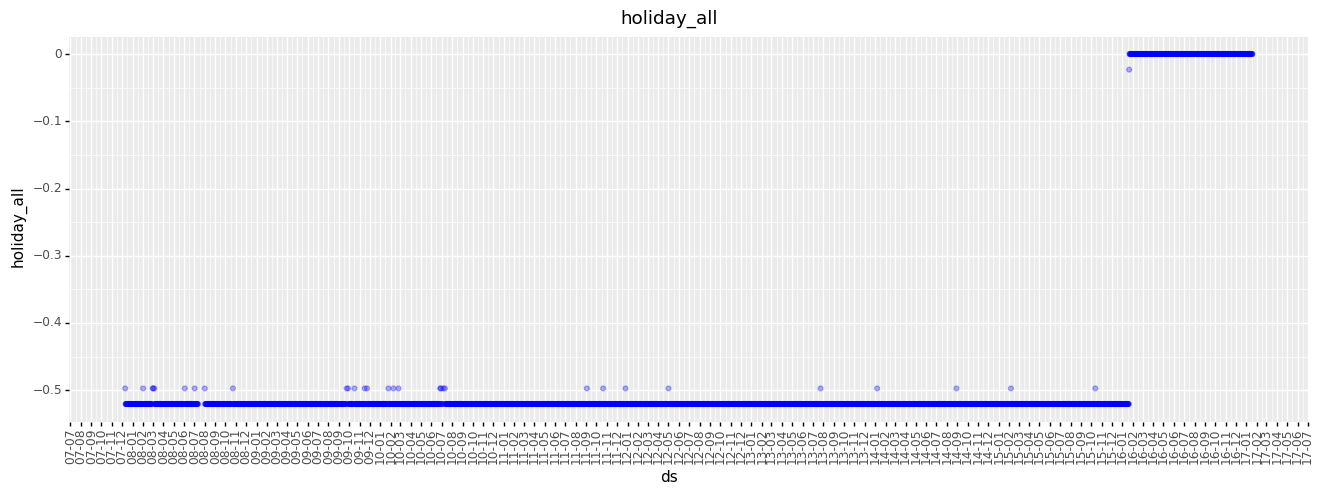

<ggplot: (8766103045289)>


In [63]:
## Viz -1
print(
    ggplot(forecast_all_holiday,aes('ds','holiday_all'))
    +geom_point(color='blue',alpha=0.3)
    +scale_x_datetime(date_breaks='1 month',date_labels='%y-%m')
    +theme(axis_text_x=element_text(angle=90),figure_size=(16,5))
    +labs(title='holiday_all')
)

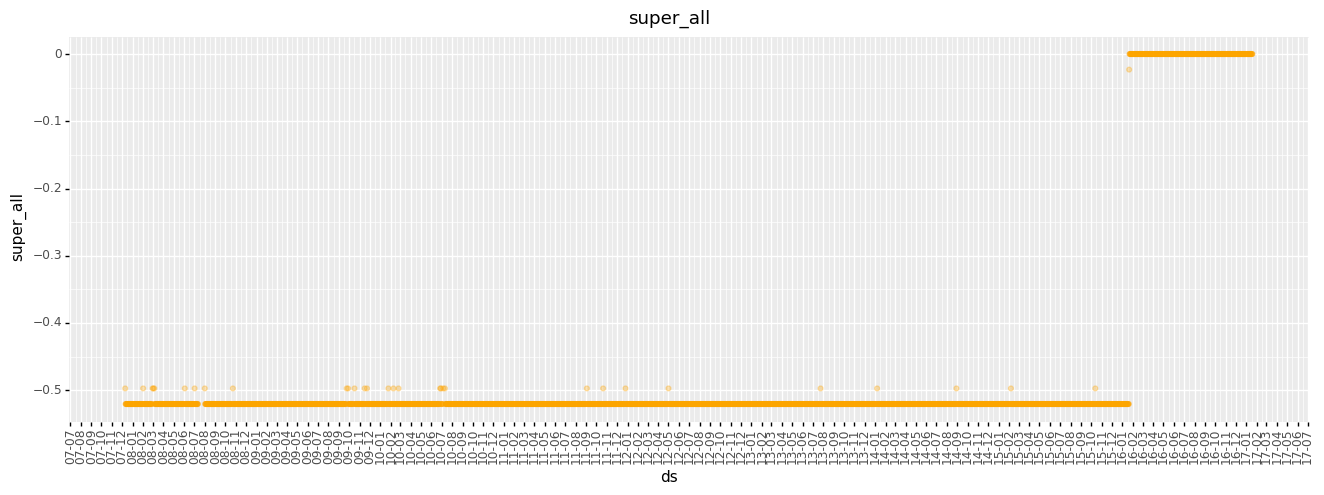

<ggplot: (8766108207761)>


In [64]:
## Viz -2
print(
    ggplot(forecast_all_holiday,aes('ds','super_all'))
    +geom_point(color='orange',alpha=0.3)
    +scale_x_datetime(date_breaks='1 month',date_labels='%y-%m')
    +theme(axis_text_x=element_text(angle=90),figure_size=(16,5))
    +labs(title='super_all')
)

In [66]:
print(forecast_all_holiday.shape)
forecast_all_holiday.loc[:,['ds','holiday_all','super_all']].groupby(['holiday_all','super_all']).size()

(3270, 28)


holiday_all  super_all
-0.520488    -0.520488    2875
-0.497275    -0.497275      30
-0.023212    -0.023212       1
 0.000000     0.000000     364
dtype: int64

In [68]:
## contribution larger than -0.5
forecast_all_holiday.loc[((forecast_all_holiday.holiday_all>-0.5)|
                         (forecast_all_holiday.super_all>-0.5))&
                         (forecast_all_holiday.holiday_all+forecast_all_holiday.super_all!=0)
                         ,['ds','holiday_all','super_all']]

,ds,holiday_all,super_all
0,2007-12-10,-0.497275,-0.497275
52,2008-02-01,-0.497275,-0.497275
79,2008-02-29,-0.497275,-0.497275
80,2008-03-02,-0.497275,-0.497275
81,2008-03-05,-0.497275,-0.497275
169,2008-06-03,-0.497275,-0.497275
197,2008-07-02,-0.497275,-0.497275
208,2008-08-01,-0.497275,-0.497275
289,2008-10-23,-0.497275,-0.497275
624,2009-09-24,-0.497275,-0.497275


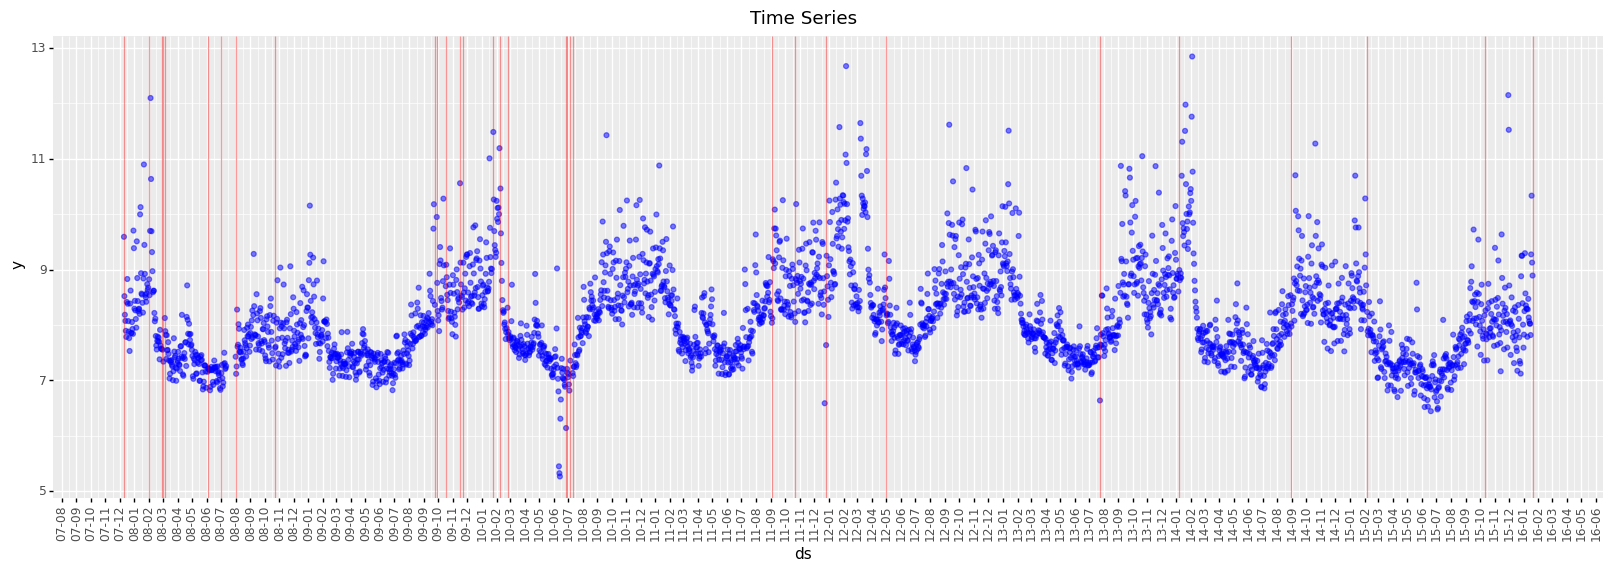

<ggplot: (8766103328139)>


In [73]:
print(
    ggplot(df,aes('ds','y'))
    +geom_point(color='blue',alpha=0.5)
    +scale_x_datetime(date_breaks='1 month',date_labels='%y-%m')
    +geom_vline(xintercept=forecast_all_holiday.loc[(forecast_all_holiday.holiday_all>-0.5)&
                                                    (forecast_all_holiday.holiday_all!=0)
                                                    ,'ds'],
                color='red',alpha=0.4)
    +theme(axis_text_x=element_text(angle=90),figure_size=(20,6))
    +labs(title='Time Series')

)

# 02 Built-in Country Holidays

## 02.1 Fitting 

In [78]:
m_cholidays=Prophet(holidays=holiday)
m_cholidays=m_cholidays.add_country_holidays(country_name='US')
m_cholidays.fit(df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [79]:
## Review holidays added
m_cholidays.train_holiday_names

0                         playoff
1                       superbowl
2                  New Year's Day
3      Martin Luther King Jr. Day
4           Washington's Birthday
5                    Memorial Day
6                Independence Day
7                       Labor Day
8                    Columbus Day
9                    Veterans Day
10                   Thanksgiving
11                  Christmas Day
12       Christmas Day (Observed)
13        Veterans Day (Observed)
14    Independence Day (Observed)
15      New Year's Day (Observed)
dtype: object

## 02.2 Predict

In [81]:
forecast_choliday=m_cholidays.predict(future)
forecast_choliday

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Christmas Day (Observed),...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2007-12-10,8.048564,8.268669,9.466035,8.048564,8.048564,0.0,0.0,0.0,0.0,...,0.341369,0.341369,0.341369,0.462275,0.462275,0.462275,0.0,0.0,0.0,8.852208
1,2007-12-11,8.046944,8.005948,9.222428,8.046944,8.046944,0.0,0.0,0.0,0.0,...,0.130337,0.130337,0.130337,0.449646,0.449646,0.449646,0.0,0.0,0.0,8.626927
2,2007-12-12,8.045323,7.851166,9.024646,8.045323,8.045323,0.0,0.0,0.0,0.0,...,-0.057331,-0.057331,-0.057331,0.438364,0.438364,0.438364,0.0,0.0,0.0,8.426355
3,2007-12-13,8.043702,7.854758,9.009485,8.043702,8.043702,0.0,0.0,0.0,0.0,...,-0.056102,-0.056102,-0.056102,0.428741,0.428741,0.428741,0.0,0.0,0.0,8.416342
4,2007-12-14,8.042082,7.830156,8.981886,8.042082,8.042082,0.0,0.0,0.0,0.0,...,-0.055856,-0.055856,-0.055856,0.421040,0.421040,0.421040,0.0,0.0,0.0,8.407266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3265,2017-01-15,7.205274,7.313928,8.685317,6.892164,7.530204,0.0,0.0,0.0,0.0,...,0.012151,0.012151,0.012151,0.777906,0.777906,0.777906,0.0,0.0,0.0,7.995330
3266,2017-01-16,7.204286,8.153858,9.493993,6.888515,7.530267,0.0,0.0,0.0,0.0,...,0.341369,0.341369,0.341369,0.796994,0.796994,0.796994,0.0,0.0,0.0,8.829808
3267,2017-01-17,7.203299,7.410834,8.813007,6.884866,7.530330,0.0,0.0,0.0,0.0,...,0.130337,0.130337,0.130337,0.816995,0.816995,0.816995,0.0,0.0,0.0,8.150631
3268,2017-01-18,7.202312,7.274008,8.680420,6.881352,7.530393,0.0,0.0,0.0,0.0,...,-0.057331,-0.057331,-0.057331,0.837695,0.837695,0.837695,0.0,0.0,0.0,7.982675


### Viz 

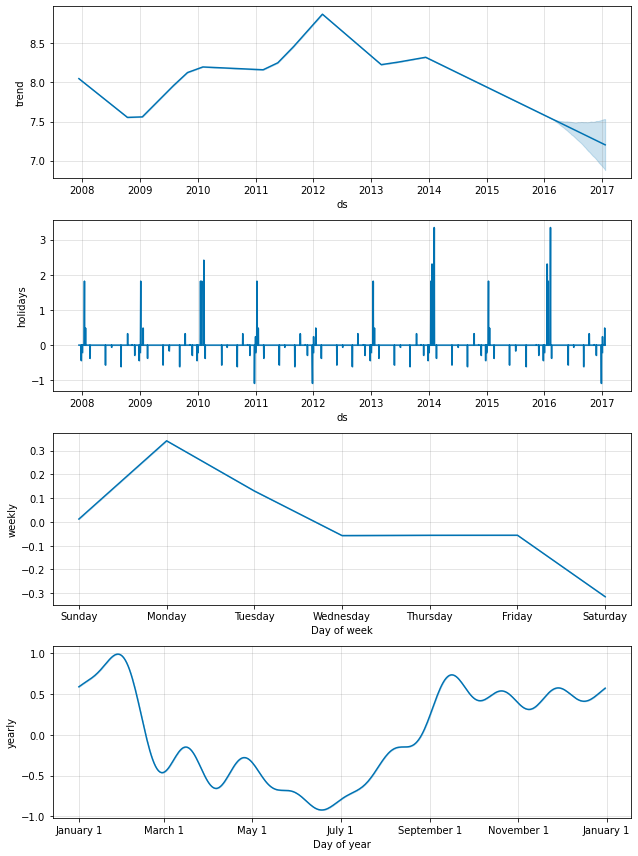

In [84]:
## Viz -1 components
fig=m_cholidays.plot_components(forecast_choliday)

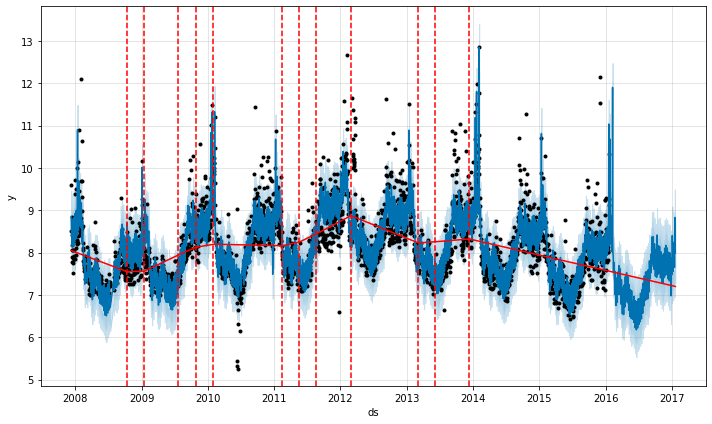

In [85]:
## Viz changepoints
fig_choliday_all=m_cholidays.plot(forecast_choliday)
a_choliday=add_changepoints_to_plot(fig_choliday_all.gca(),
                                    m_cholidays,
                                    forecast_choliday
                                   )

In [ ]:
## Need to highlight the impact of adding US holidays

## 02.3 Review

### Raw Output 

In [173]:
#forecast_choliday.columns
forecast_choliday.columns # 

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'Christmas Day', 'Christmas Day_lower', 'Christmas Day_upper',
       'Christmas Day (Observed)', 'Christmas Day (Observed)_lower',
       'Christmas Day (Observed)_upper', 'Columbus Day', 'Columbus Day_lower',
       'Columbus Day_upper', 'Independence Day', 'Independence Day_lower',
       'Independence Day_upper', 'Independence Day (Observed)',
       'Independence Day (Observed)_lower',
       'Independence Day (Observed)_upper', 'Labor Day', 'Labor Day_lower',
       'Labor Day_upper', 'Martin Luther King Jr. Day',
       'Martin Luther King Jr. Day_lower', 'Martin Luther King Jr. Day_upper',
       'Memorial Day', 'Memorial Day_lower', 'Memorial Day_upper',
       'New Year's Day', 'New Year's Day_lower', 'New Year's Day_upper',
       'New Year's Day (Observed)', 'New Year's Day (Observed)_lower',
       'New Year's Day (Observed)_upper', 'Thanksgiving', 'Thanksgiving_lower',
       'Thanksgiv

In [98]:
forecast_choliday_review=forecast_choliday.melt(id_vars='ds',
                                                value_vars=m_cholidays.train_holiday_names,
                                                var_name='holiday',
                                                value_name='vals'
                                               ).loc[lambda x:x.vals!=0,:].reset_index(drop=True)
forecast_choliday_review.loc[:,'impact']=np.where(forecast_choliday_review.vals>0,'positive','negative')

print(forecast_choliday_review.shape)
print(forecast_choliday_review.holiday.value_counts())
print(forecast_choliday_review.ds.min(),
      forecast_choliday_review.ds.max())
forecast_choliday_review.head(5)

(131, 4)
playoff                        26
Martin Luther King Jr. Day     10
New Year's Day                 10
Thanksgiving                    9
Christmas Day                   9
Labor Day                       9
Veterans Day                    9
Memorial Day                    9
Washington's Birthday           9
Independence Day                9
Columbus Day                    8
superbowl                       5
Christmas Day (Observed)        3
New Year's Day (Observed)       3
Independence Day (Observed)     2
Veterans Day (Observed)         1
Name: holiday, dtype: int64
2007-12-25 00:00:00 2017-01-16 00:00:00


,ds,holiday,vals,impact
0,2008-01-13,playoff,1.242302,positive
1,2008-01-14,playoff,1.819752,positive
2,2009-01-03,playoff,1.242302,positive
3,2009-01-04,playoff,1.819752,positive
4,2010-01-16,playoff,1.242302,positive


In [164]:
forecast_choliday_review.loc[~forecast_choliday_review.holiday.isin(['playoff','superbowl']),
                             :].groupby(['holiday','vals']).agg(num_records=('ds','nunique')).sort_values(by='vals',ascending=False)

,,num_records
holiday,vals,
Martin Luther King Jr. Day,0.487159,10
Columbus Day,0.326980,8
New Year's Day (Observed),0.241084,3
Veterans Day,0.013470,9
Veterans Day (Observed),0.010226,1
Independence Day,-0.062851,9
Independence Day (Observed),-0.167480,2
New Year's Day,-0.214653,10
Thanksgiving,-0.292687,9


In [95]:
forecast_choliday_review.groupby('holiday').describe() # public holiday tends to have the same impact

vals                                              \
                            count      mean           std       min       25%   
holiday                                                                         
Christmas Day                 9.0 -0.440643  0.000000e+00 -0.440643 -0.440643   
Christmas Day (Observed)      3.0 -1.088522  0.000000e+00 -1.088522 -1.088522   
Columbus Day                  8.0  0.326980  5.934392e-17  0.326980  0.326980   
Independence Day              9.0 -0.062851  0.000000e+00 -0.062851 -0.062851   
Independence Day (Observed)   2.0 -0.167480  0.000000e+00 -0.167480 -0.167480   
Labor Day                     9.0 -0.612812  0.000000e+00 -0.612812 -0.612812   
Martin Luther King Jr. Day   10.0  0.487159  5.851389e-17  0.487159  0.487159   
Memorial Day                  9.0 -0.567381  0.000000e+00 -0.567381 -0.567381   
New Year's Day               10.0 -0.214653  2.925695e-17 -0.214653 -0.214653   
New Year's Day (Observed)     3.0  0.241084  0.000000e+00  0.241084  0.241084   
Thanksgiving                  9.0 -0.292687  5.887847e-17 -0.292687 -0.292687   
Veterans Day                  9.0  0.013470  1.839952e-18  0.013470  0.013470   
Veterans Day (Observed)       1.0  0.010226           NaN  0.010226  0.010226   
Washington's Birthday         9.0 -0.376489  5.887847e-17 -0.376489 -0.376489   
playoff                      26.0  1.531027  2.944430e-01  1.242302  1.242302   
superbowl                     5.0  1.313562  1.922020e-01  1.173197  1.173197   

                                                           
                                  50%       75%       max  
holiday                                                    
Christmas Day               -0.440643 -0.440643 -0.440643  
Christmas Day (Observed)    -1.088522 -1.088522 -1.088522  
Columbus Day                 0.326980  0.326980  0.326980  
Independence Day            -0.062851 -0.062851 -0.062851  
Independence Day (Observed) -0.167480 -0.167480 -0.167480  
Labor Day                   -0.612812 -0.612812 -0.612812  
Martin Luther King Jr. Day   0.487159  0.487159  0.487159  
Memorial Day                -0.567381 -0.567381 -0.567381  
New Year's Day              -0.214653 -0.214653 -0.214653  
New Year's Day (Observed)    0.241084  0.241084  0.241084  
Thanksgiving                -0.292687 -0.292687 -0.292687  
Veterans Day                 0.013470  0.013470  0.013470  
Veterans Day (Observed)      0.010226  0.010226  0.010226  
Washington's Birthday       -0.376489 -0.376489 -0.376489  
playoff                      1.531027  1.819752  1.819752  
superbowl                    1.173197  1.524108  1.524108

### Review 

#### Holiday Impact 

In [109]:
## Data Processing
df_review=df.copy()
df_review.loc[:,'cat']='Actual'

df_review=pd.concat([df_review,
                     forecast_choliday.loc[:,['ds','yhat']].rename(columns={'yhat':'y'}).assign(cat='Prediction')
                    ],axis=0)
print(df_review.shape)
print(df_review.cat.value_counts())
df_review.head(5)

(6175, 3)
Prediction    3270
Actual        2905
Name: cat, dtype: int64


,ds,y,cat
0,2007-12-10,9.590761,Actual
1,2007-12-11,8.519590,Actual
2,2007-12-12,8.183677,Actual
3,2007-12-13,8.072467,Actual
4,2007-12-14,7.893572,Actual


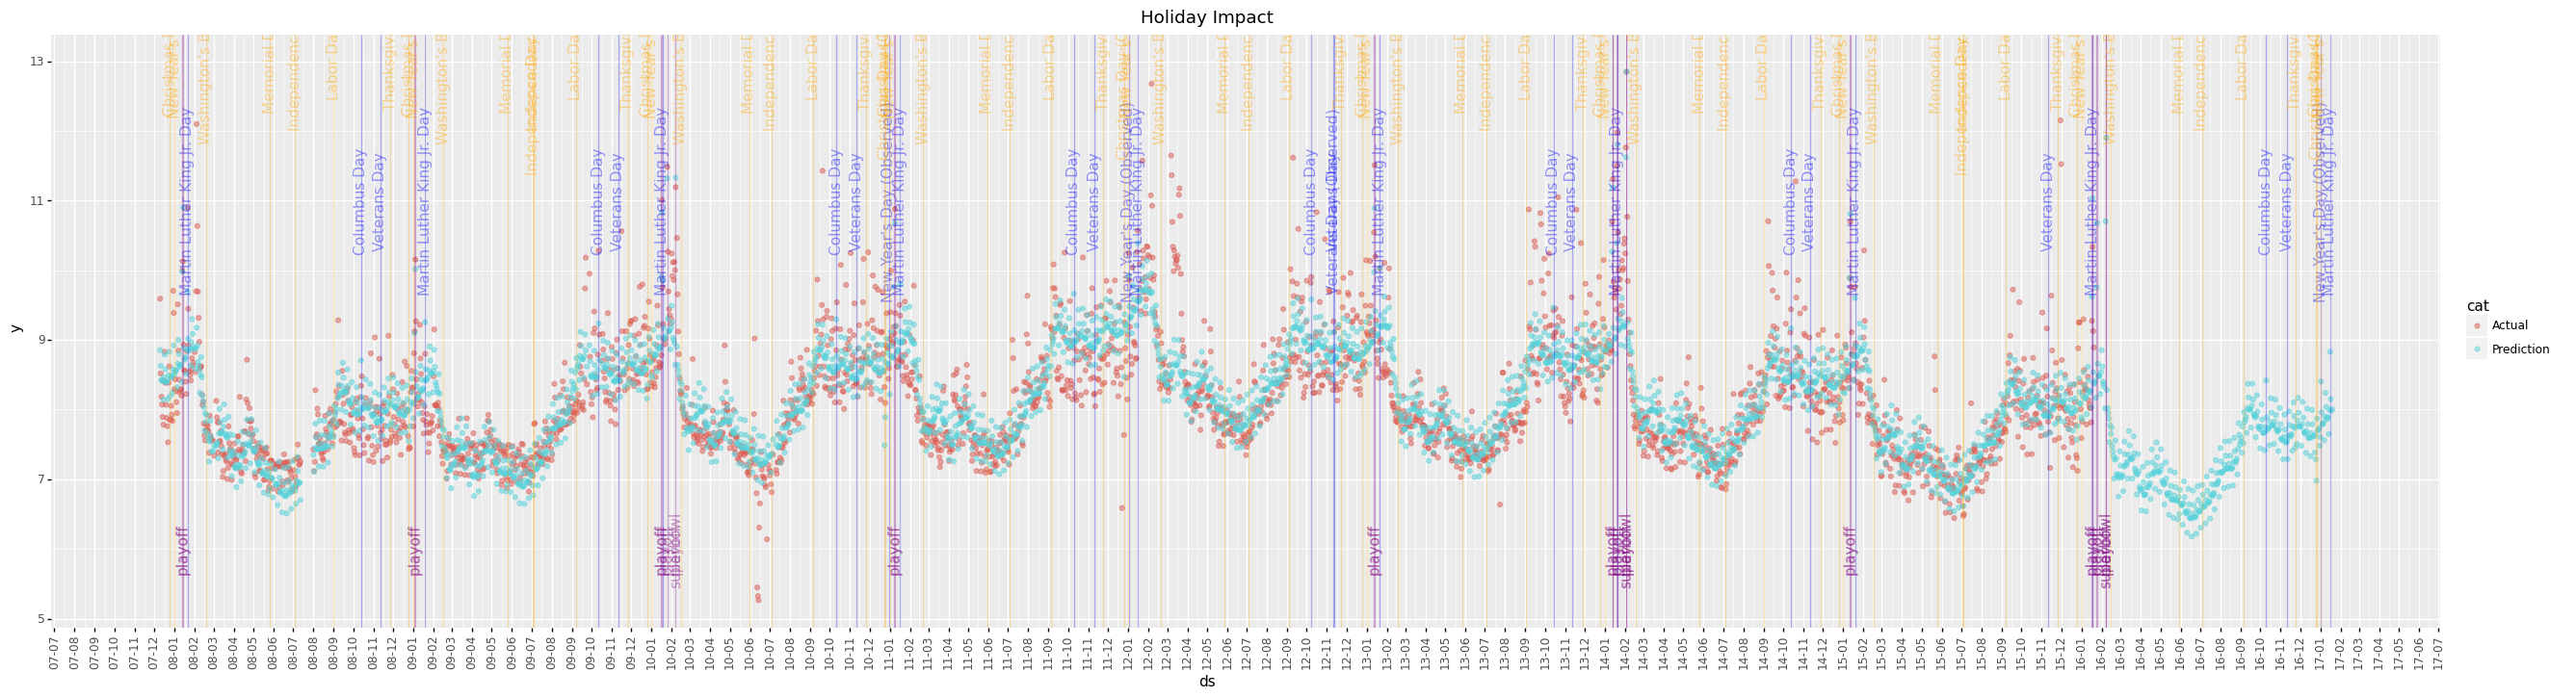

<ggplot: (8766108065687)>


In [130]:
## Viz -1 Holiday Impact on Prediction
print(
    ggplot(df_review,aes('ds','y',color='cat'))
    +geom_point(alpha=0.5)
    ## Positive ##
    # country holiday
    +geom_vline(xintercept=forecast_choliday_review.loc[(forecast_choliday_review.impact=='positive')&
                                                        (~forecast_choliday_review.holiday.isin(['playoff','superbowl']))
                                                        ,'ds'],
                color='blue',
                alpha=0.3)
    +geom_text(aes(label='holiday'),
               forecast_choliday_review.loc[(forecast_choliday_review.impact=='positive')&
                                            (~forecast_choliday_review.holiday.isin(['playoff','superbowl']))
                                            ,:].assign(y=11),
               color='blue',
               angle=90,
               alpha=0.4
              )
    # additional holiday
    +geom_vline(xintercept=forecast_choliday_review.loc[(forecast_choliday_review.impact=='positive')&
                                                        (forecast_choliday_review.holiday.isin(['playoff','superbowl']))
                                                        ,'ds'],
                color='purple',
                alpha=0.3)
    
    +geom_text(aes(label='holiday'),
               forecast_choliday_review.loc[(forecast_choliday_review.impact=='positive')&
                                            (forecast_choliday_review.holiday.isin(['playoff','superbowl']))
                                            ,:].assign(y=6),
               color='purple',
               angle=90,
               alpha=0.4
              )
    ## Negative ##
    # country holiday
    +geom_vline(xintercept=forecast_choliday_review.loc[forecast_choliday_review.impact=='negative','ds'],
                color='orange',alpha=0.3
               )
    +geom_text(aes(label='holiday'),
               forecast_choliday_review.loc[forecast_choliday_review.impact=='negative',:].assign(y=13),
               color='orange',
               angle=90,
               alpha=0.4
               
              )
    +scale_x_datetime(date_breaks='1 month',date_labels='%y-%m')
    +theme(axis_text_x=element_text(angle=90),figure_size=(32,8))
    +labs(title='Holiday Impact')
)

In [114]:
forecast_choliday_review.loc[forecast_choliday_review.impact=='Positive','ds']

Series([], Name: ds, dtype: datetime64[ns])

#### Non-Holiday Impact 

In [134]:
df_review_nonholiday=df.copy()
df_review_nonholiday.loc[:,'cat']='Actual'

df_review_nonholiday=pd.concat([df_review_nonholiday,
                                forecast.loc[:,['ds','yhat']].rename(columns={'yhat':'y'}).assign(cat='Prediction')# only playoff and superbowl impact
                               ],axis=0)
print(df_review_nonholiday.shape)
print(df_review_nonholiday.cat.value_counts())
df_review_nonholiday.head(5)

(6175, 3)
Prediction    3270
Actual        2905
Name: cat, dtype: int64


,ds,y,cat
0,2007-12-10,9.590761,Actual
1,2007-12-11,8.519590,Actual
2,2007-12-12,8.183677,Actual
3,2007-12-13,8.072467,Actual
4,2007-12-14,7.893572,Actual


In [144]:
forecast_review=forecast.melt(id_vars='ds',
                              value_vars=['superbowl','playoff'],
                              var_name='holiday',
                              value_name='vals'
                              ).loc[lambda x:x.vals>0,:].reset_index(drop=True)
forecast_review.head(5)

,ds,holiday,vals
0,2010-02-07,superbowl,1.214678
1,2014-02-02,superbowl,1.214678
2,2014-02-03,superbowl,1.460850
3,2016-02-07,superbowl,1.214678
4,2016-02-08,superbowl,1.460850


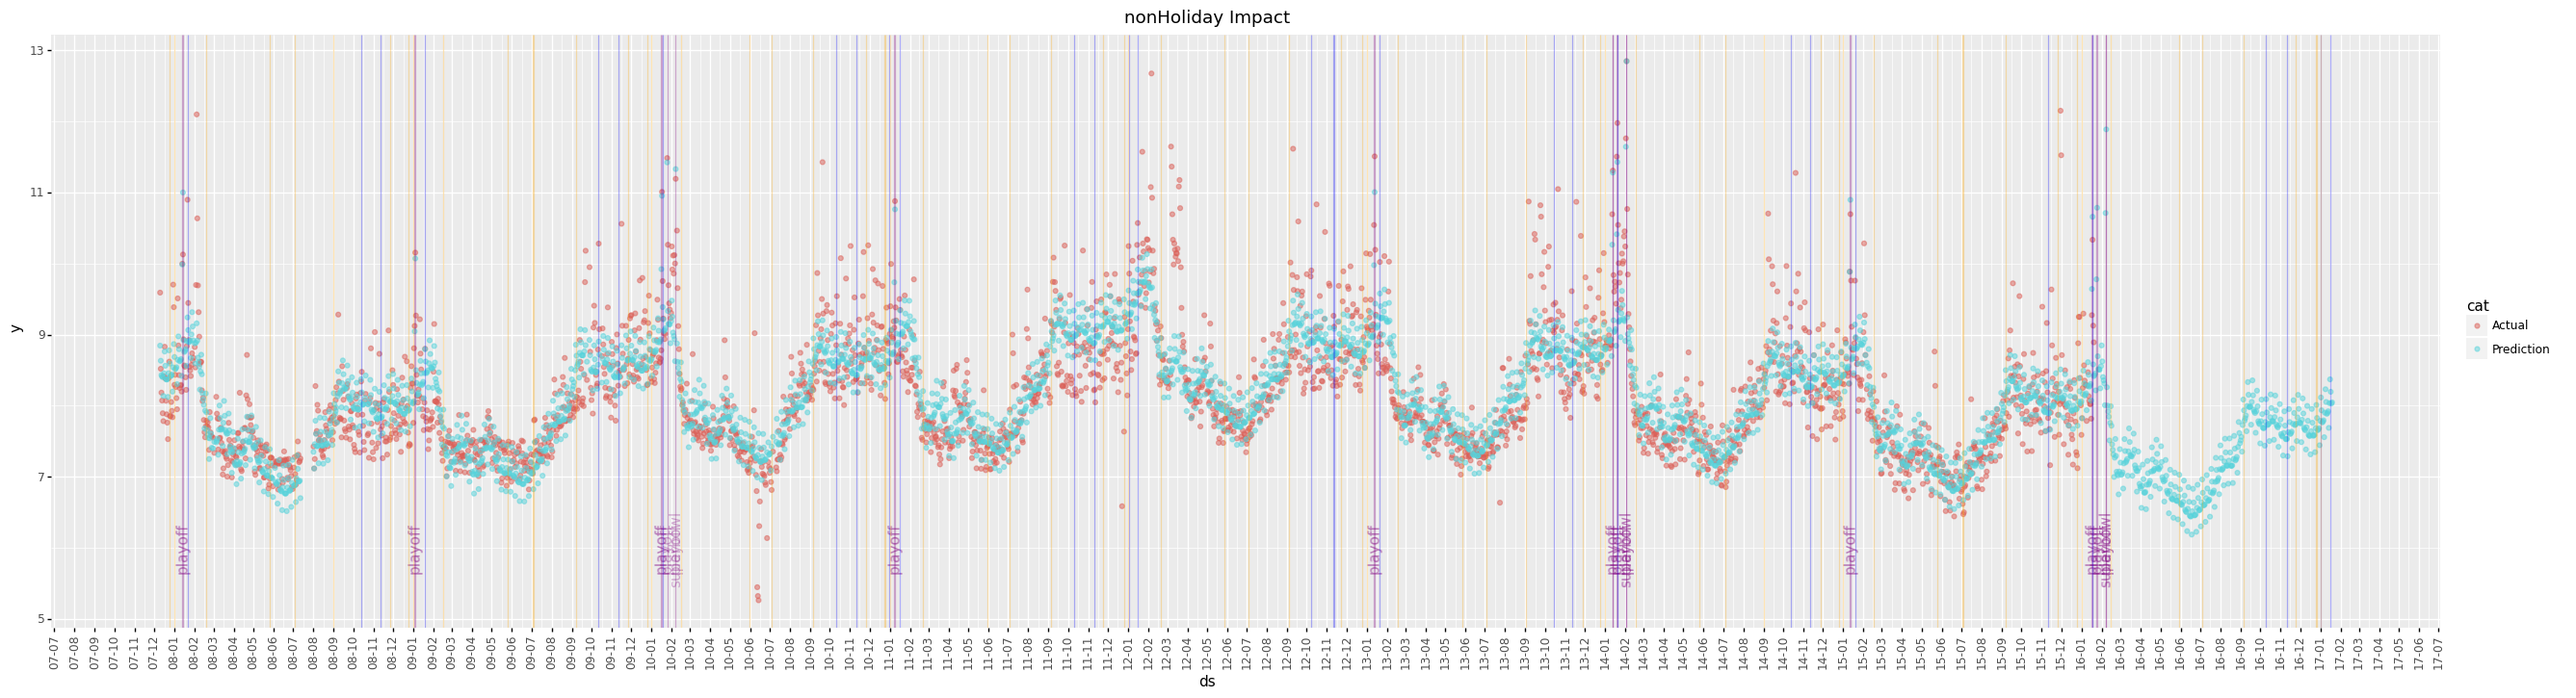

<ggplot: (8766108031597)>


In [160]:
## Viz -2
print(
    ggplot(df_review_nonholiday,aes('ds','y',color='cat'))
    +geom_point(alpha=0.5)
    ## refernece line
    +geom_vline(xintercept=forecast_review.loc[:,'ds'],
                color='purple',
                alpha=0.3
               )
    +geom_text(aes(label='holiday'),
               forecast_review.assign(y=6),
               color='purple',
               angle=90,
               alpha=0.3
              )
    
    ## Reference line - positive
    +geom_vline(xintercept=forecast_choliday_review.loc[(forecast_choliday_review.impact=='positive')&
                                                        (~forecast_choliday_review.holiday.isin(['playoff','superbowl']))
                                                        ,'ds'],
                color='blue',
                alpha=0.3)
    ## Reference line - negative
    +geom_vline(xintercept=forecast_choliday_review.loc[forecast_choliday_review.impact=='negative','ds'],
                color='orange',alpha=0.3
               )
    +scale_x_datetime(date_breaks='1 month',date_labels='%y-%m')
    +theme(axis_text_x=element_text(angle=90),figure_size=(32,8))
    +labs(title='nonHoliday Impact')

)

#### Comparing Differences 

In [155]:
forecast_choliday_review_2=pd.merge(forecast_choliday_review.loc[~forecast_choliday_review.holiday.isin(['playoff','superbowl']),:],
                                    forecast_choliday.loc[:,['ds','yhat']],
                                    how='left',
                                    on='ds'
                                   )
print(forecast_choliday_review_2.shape)

(100, 5)


In [162]:
pd.merge(forecast_choliday_review_2,
         forecast.loc[:,['ds','yhat']].rename(columns={'yhat':'yhat_non_choliday'}),
         how='left',
         on='ds'
        ).assign(diff=lambda x:x.yhat-x.yhat_non_choliday).sort_values(by='ds',ascending=True)[:25]

,ds,holiday,vals,impact,yhat,yhat_non_choliday,diff
82,2007-12-25,Christmas Day,-0.440643,negative,8.190554,8.591528,-0.400974
0,2008-01-01,New Year's Day,-0.214653,negative,8.507063,8.685472,-0.178409
10,2008-01-21,Martin Luther King Jr. Day,0.487159,positive,9.694248,9.241802,0.452446
20,2008-02-18,Washington's Birthday,-0.376489,negative,7.825109,8.171880,-0.346770
29,2008-05-26,Memorial Day,-0.567381,negative,6.865334,7.388849,-0.523515
38,2008-07-04,Independence Day,-0.062851,negative,6.835719,6.890082,-0.054363
47,2008-09-01,Labor Day,-0.612812,negative,7.605321,8.175028,-0.569706
56,2008-10-13,Columbus Day,0.326980,positive,8.704588,8.372490,0.332098
64,2008-11-11,Veterans Day,0.013470,positive,8.023445,8.004168,0.019277
73,2008-11-27,Thanksgiving,-0.292687,negative,7.779509,8.055832,-0.276323


# 03 Fourier Order For Seasonality

## 03.1 Fitting

### Default - 10 

In [165]:
from prophet.plot import plot_yearly

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


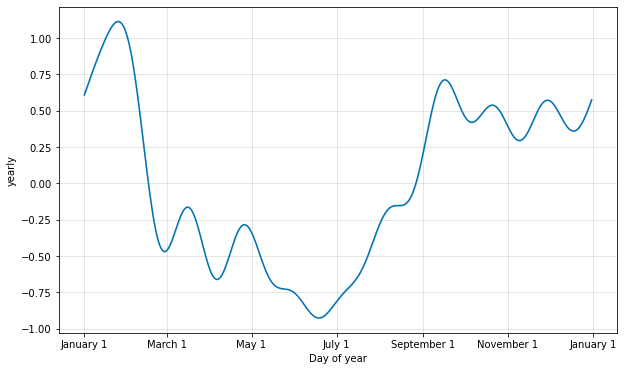

In [167]:
m_sea=Prophet().fit(df)
a_sea=plot_yearly(m_sea)

### Change to 20 

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


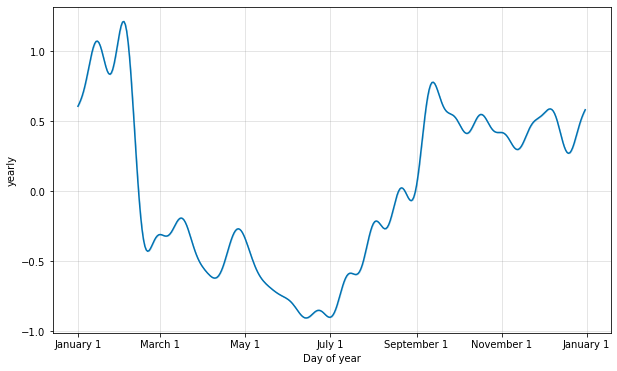

In [168]:
m_sea20=Prophet(yearly_seasonality=20).fit(df)
a_sea20=plot_yearly(m_sea20)

# 04 Specifying Custom Seasonality 

In [174]:
forecast.columns # default: Fourier 3 for weekly seasonality, 10 for yearly seasonality

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'holidays', 'holidays_lower', 'holidays_upper', 'playoff',
       'playoff_lower', 'playoff_upper', 'superbowl', 'superbowl_lower',
       'superbowl_upper', 'weekly', 'weekly_lower', 'weekly_upper', 'yearly',
       'yearly_lower', 'yearly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')

## 04.1 Configuring 

In [171]:
m_csea=Prophet(weekly_seasonality=False)
m_csea.add_seasonality(name='monthly',
                       period=30.5,
                       fourier_order=5).fit(df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


## 04.2 Forecasting 

In [175]:
forecast_csea=m_csea.predict(future)
forecast_csea.head(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,monthly,monthly_lower,monthly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2007-12-10,8.033198,7.787161,9.148545,8.033198,8.033198,0.455143,0.455143,0.455143,-0.001678,-0.001678,-0.001678,0.456821,0.456821,0.456821,0.0,0.0,0.0,8.488341
1,2007-12-11,8.031689,7.827685,9.157206,8.031689,8.031689,0.423674,0.423674,0.423674,-0.016149,-0.016149,-0.016149,0.439824,0.439824,0.439824,0.0,0.0,0.0,8.455364
2,2007-12-12,8.030181,7.768097,9.108283,8.030181,8.030181,0.395578,0.395578,0.395578,-0.028104,-0.028104,-0.028104,0.423682,0.423682,0.423682,0.0,0.0,0.0,8.425759
3,2007-12-13,8.028672,7.741212,9.090749,8.028672,8.028672,0.379623,0.379623,0.379623,-0.029212,-0.029212,-0.029212,0.408835,0.408835,0.408835,0.0,0.0,0.0,8.408295
4,2007-12-14,8.027164,7.774918,9.084091,8.027164,8.027164,0.380302,0.380302,0.380302,-0.015385,-0.015385,-0.015385,0.395687,0.395687,0.395687,0.0,0.0,0.0,8.407466


## 04.3 Viz 

### Overall trend 

/home/ubuntu/anaconda3/lib/python3.8/site-packages/plotnine/scales/scale.py:103: PlotnineWarning: scale_x_datetime could not recognise parameter `date_label`
/home/ubuntu/anaconda3/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_point : Removed 5875 rows containing missing values.


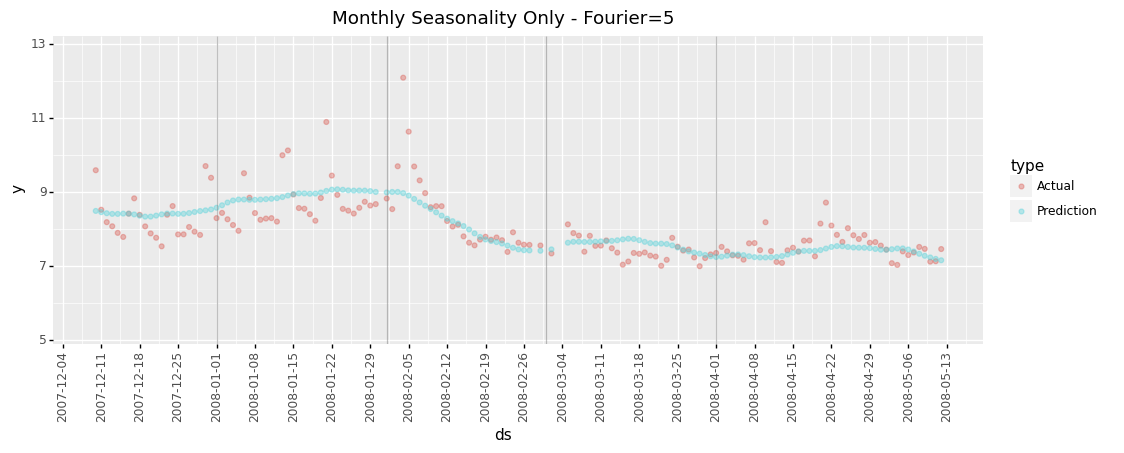

<ggplot: (8766108451819)>


In [214]:
## Custom seasonality
cust_sea_review=pd.concat([df.assign(type='Actual'),
                           forecast_csea.loc[:,['ds','yhat']].rename(columns={'yhat':'y'}).assign(type='Prediction')
                          ])
print(
    ggplot(cust_sea_review,aes('ds','y',color='type'))
    +geom_point(alpha=0.4)
    #+scale_x_datetime(date_breaks='1 month',date_label='%Y-%m')
    +scale_x_datetime(date_label='%m-%d',
                      date_breaks='1 week',
                      limits=[pd.to_datetime('2007-12-10'),pd.to_datetime('2008-05-12')])
    +geom_vline(xintercept=[pd.to_datetime('2008-01-01'),
                            pd.to_datetime('2008-02-01'),
                            pd.to_datetime('2008-03-01'),
                            pd.to_datetime('2008-04-01')
                           ],color='grey',alpha=0.5)
    #+theme(axis_text_x=element_text(angle=90),figure_size=(32,8))
    +theme(axis_text_x=element_text(angle=90),figure_size=(12,4))
    +labs(title='Monthly Seasonality Only - Fourier=5')
)

/home/ubuntu/anaconda3/lib/python3.8/site-packages/plotnine/scales/scale.py:103: PlotnineWarning: scale_x_datetime could not recognise parameter `date_label`
/home/ubuntu/anaconda3/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_point : Removed 5875 rows containing missing values.


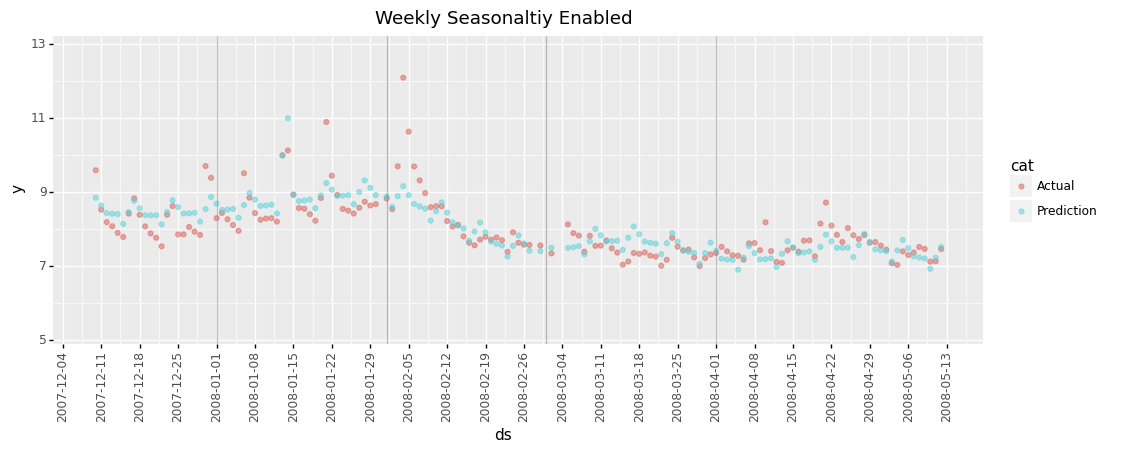

<ggplot: (8766108346570)>


In [213]:
## Default Fourier/ Weekly Seasonality
print(
    ggplot(df_review_nonholiday,aes('ds','y',color='cat'))
    +geom_point(alpha=0.5)
    +scale_x_datetime(date_label='%m-%d',
                      date_breaks='1 week',
                      limits=[pd.to_datetime('2007-12-10'),pd.to_datetime('2008-05-12')])
    +theme(axis_text_x=element_text(angle=90),figure_size=(12,4))
    +geom_vline(xintercept=[pd.to_datetime('2008-01-01'),
                            pd.to_datetime('2008-02-01'),
                            pd.to_datetime('2008-03-01'),
                            pd.to_datetime('2008-04-01')
                           ],color='grey',alpha=0.5)
    #+scale_x_datetime(date_breaks='1 month',date_labels='%y-%m')
    #+theme(axis_text_x=element_text(angle=90),figure_size=(32,8))
    +labs(title='Weekly Seasonaltiy Enabled')

)

### Add Change Points 

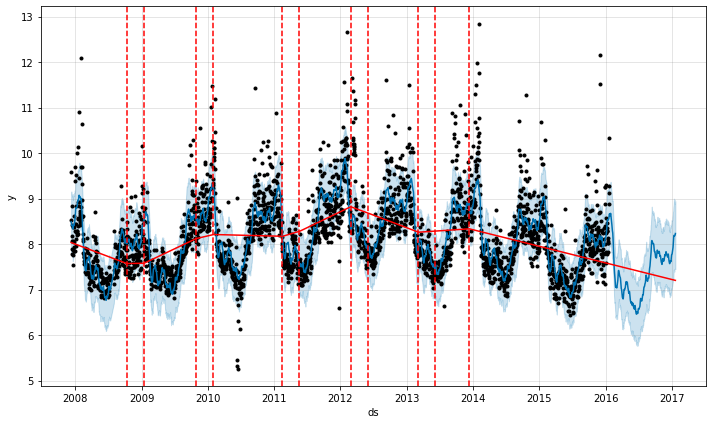

In [220]:
## Monthly Seasonality
fig_csea=m_csea.plot(forecast_csea)
a_csea=add_changepoints_to_plot(fig_csea.gca(),
                                m_sea,
                                forecast_csea
                               )

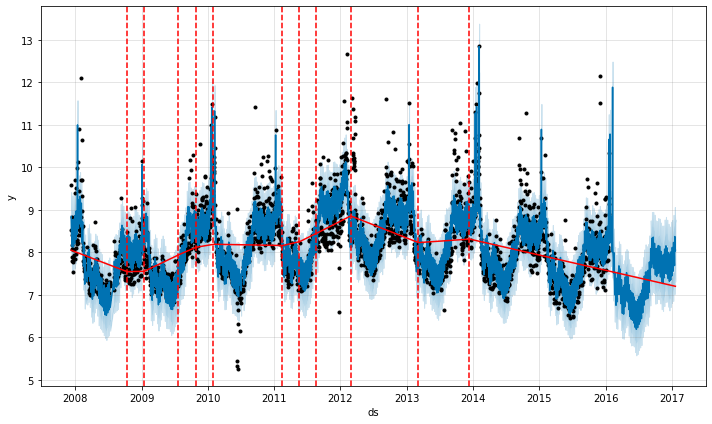

In [177]:
## default
fig=m.plot(forecast)
a=add_changepoints_to_plot(fig.gca(),m,forecast)

### Component Plots 

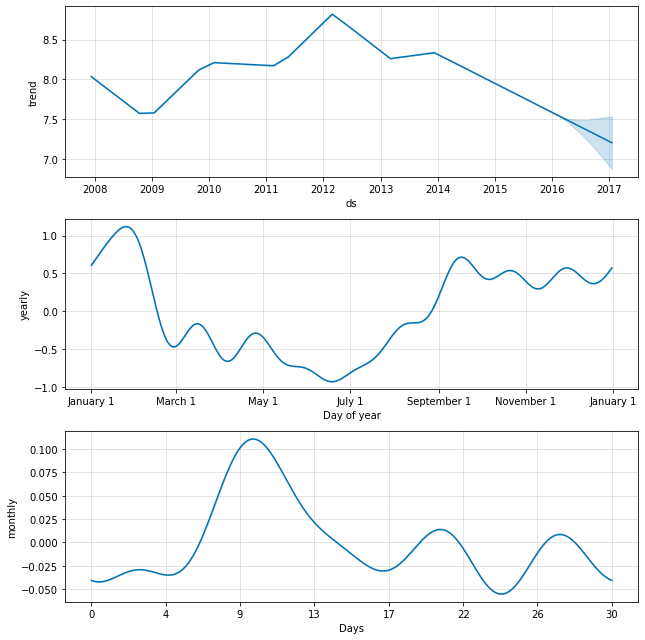

In [221]:
## Monthly Seasonality
fig_csea_com=m_csea.plot_components(forecast_csea)

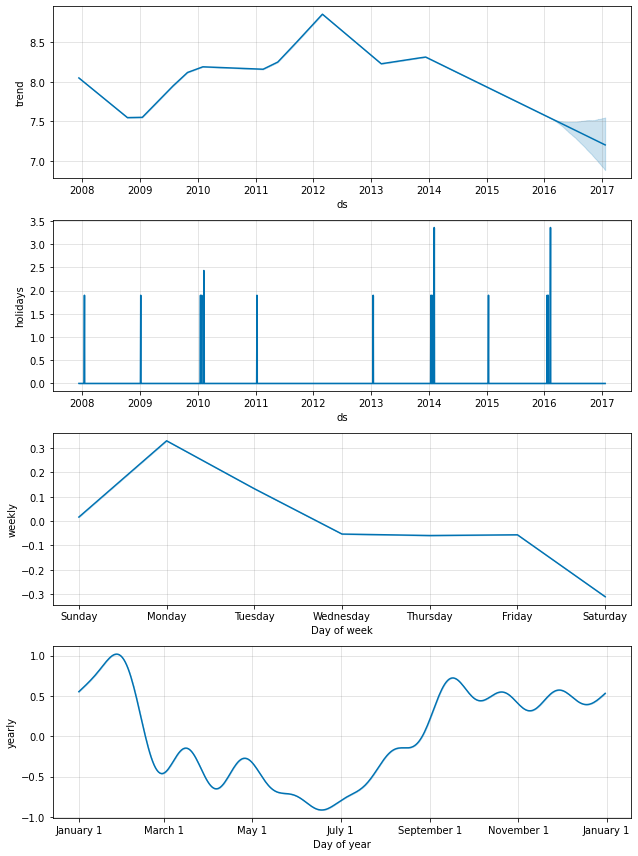

In [222]:
## Default weekly seasonality
fig_com=m.plot_components(forecast)

# 05 Seasonality that depend on other factors

## 5.1 Basic Table 

In [223]:
def is_nfl_season(ds):
    date=pd.to_datetime(ds)
    return(date.month>8 or date.month<2)

In [228]:
df.loc[:,'on_season']=df['ds'].apply(is_nfl_season)
df.loc[:,'off_season']=~df['ds'].apply(is_nfl_season)
df.head(5)

,ds,y,on_season,off_season
0,2007-12-10,9.590761,True,False
1,2007-12-11,8.519590,True,False
2,2007-12-12,8.183677,True,False
3,2007-12-13,8.072467,True,False
4,2007-12-14,7.893572,True,False


## 5.2 Configuring 

In [232]:
m_addsea=Prophet(weekly_seasonality=False) # disable default weekly seasonality
m_addsea.add_seasonality(name='weekly_on_season',
                         period=7,
                         fourier_order=3,
                         condition_name='on_season' # input values: True
                        )
m_addsea.add_seasonality(name='weekly_off_season',
                         period=7,
                         fourier_order=3,
                         condition_name='off_season' # input values: True
                        )
m_addsea.fit(df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


## 5.3 Predicting 

In [235]:
future_addsea=future.copy()
## adding on_season and off_season
future_addsea.loc[:,'on_season']=future.loc[:,'ds'].apply(is_nfl_season)
future_addsea.loc[:,'off_season']=~future.loc[:,'ds'].apply(is_nfl_season)
future_addsea.head(5)

,ds,on_season,off_season
0,2007-12-10,True,False
1,2007-12-11,True,False
2,2007-12-12,True,False
3,2007-12-13,True,False
4,2007-12-14,True,False


In [239]:
## Predicting
forecast_addsea=m_addsea.predict(future_addsea)
forecast_addsea.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly_off_season', 'weekly_off_season_lower',
       'weekly_off_season_upper', 'weekly_on_season', 'weekly_on_season_lower',
       'weekly_on_season_upper', 'yearly', 'yearly_lower', 'yearly_upper',
       'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')

In [246]:
forecast_addsea_si=forecast_addsea.loc[:,['ds','weekly_on_season','weekly_off_season']].assign(weekday=lambda x:x.ds.dt.weekday+1)
forecast_addsea_si.loc[:,'weekly_on_season_si']=round(forecast_addsea_si.weekly_on_season,6)
forecast_addsea_si.loc[:,'weekly_off_season_si']=round(forecast_addsea_si.weekly_off_season,6)
## weekly_on_season
forecast_addsea_si.groupby([forecast_addsea_si.weekly_on_season==0,'weekday','weekly_on_season_si']).size()[:15]


weekly_on_season  weekday  weekly_on_season_si
False             1         0.708693              200
                  2         0.179234              202
                  3        -0.228728              200
                  4        -0.267255              202
                  5        -0.205019              199
                  6        -0.469125              199
                  7         0.282200              196
True              1         0.000000              265
                  2         0.000000              266
                  3         0.000000              269
                  4         0.000000              264
                  5         0.000000              270
                  6         0.000000              268
                  7         0.000000              270
dtype: int64

In [247]:
## weekly_off_season
forecast_addsea_si.groupby([forecast_addsea_si.weekly_off_season==0,'weekday','weekly_off_season_si']).size()[:15]

weekly_off_season  weekday  weekly_off_season_si
False              1         0.079648               265
                   2         0.073533               266
                   3         0.055175               269
                   4         0.076899               264
                   5         0.030344               270
                   6        -0.194538               268
                   7        -0.121062               270
True               1         0.000000               200
                   2         0.000000               202
                   3         0.000000               200
                   4         0.000000               202
                   5         0.000000               199
                   6         0.000000               199
                   7         0.000000               196
dtype: int64

## 5.4 Viz 

### Components 

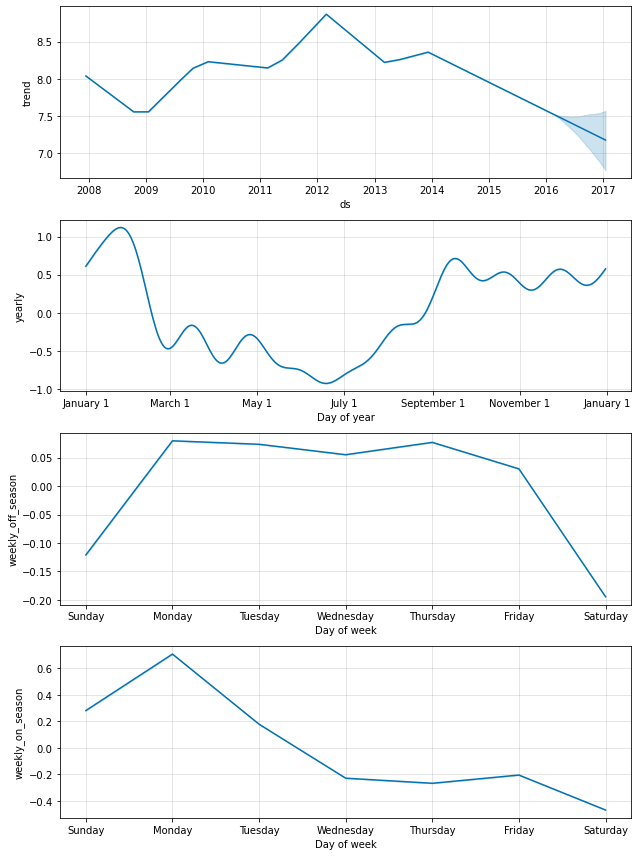

In [251]:
fig_addsea=m_addsea.plot_components(forecast_addsea)

### Trend

In [270]:
## data processing
forecast_addsea_review=pd.concat([df.assign(type='actual'),
                                  forecast_addsea.loc[:,['ds','yhat']].assign(on_season=forecast_addsea.weekly_on_season!=0,
                                                                              off_season=forecast_addsea.weekly_off_season!=0,
                                                                              type='forecast').rename(columns={'yhat':'y'})
                                 ],axis=0)
forecast_addsea_review.loc[:,'y2']=6.75
print(forecast_addsea_review)

             ds         y  on_season  off_season      type    y2
0    2007-12-10  9.590761       True       False    actual  6.75
1    2007-12-11  8.519590       True       False    actual  6.75
2    2007-12-12  8.183677       True       False    actual  6.75
3    2007-12-13  8.072467       True       False    actual  6.75
4    2007-12-14  7.893572       True       False    actual  6.75
...         ...       ...        ...         ...       ...   ...
3265 2017-01-15  8.436363       True       False  forecast  6.75
3266 2017-01-16  8.884103       True       False  forecast  6.75
3267 2017-01-17  8.374990       True       False  forecast  6.75
3268 2017-01-18  7.986268       True       False  forecast  6.75
3269 2017-01-19  7.965618       True       False  forecast  6.75

[6175 rows x 6 columns]


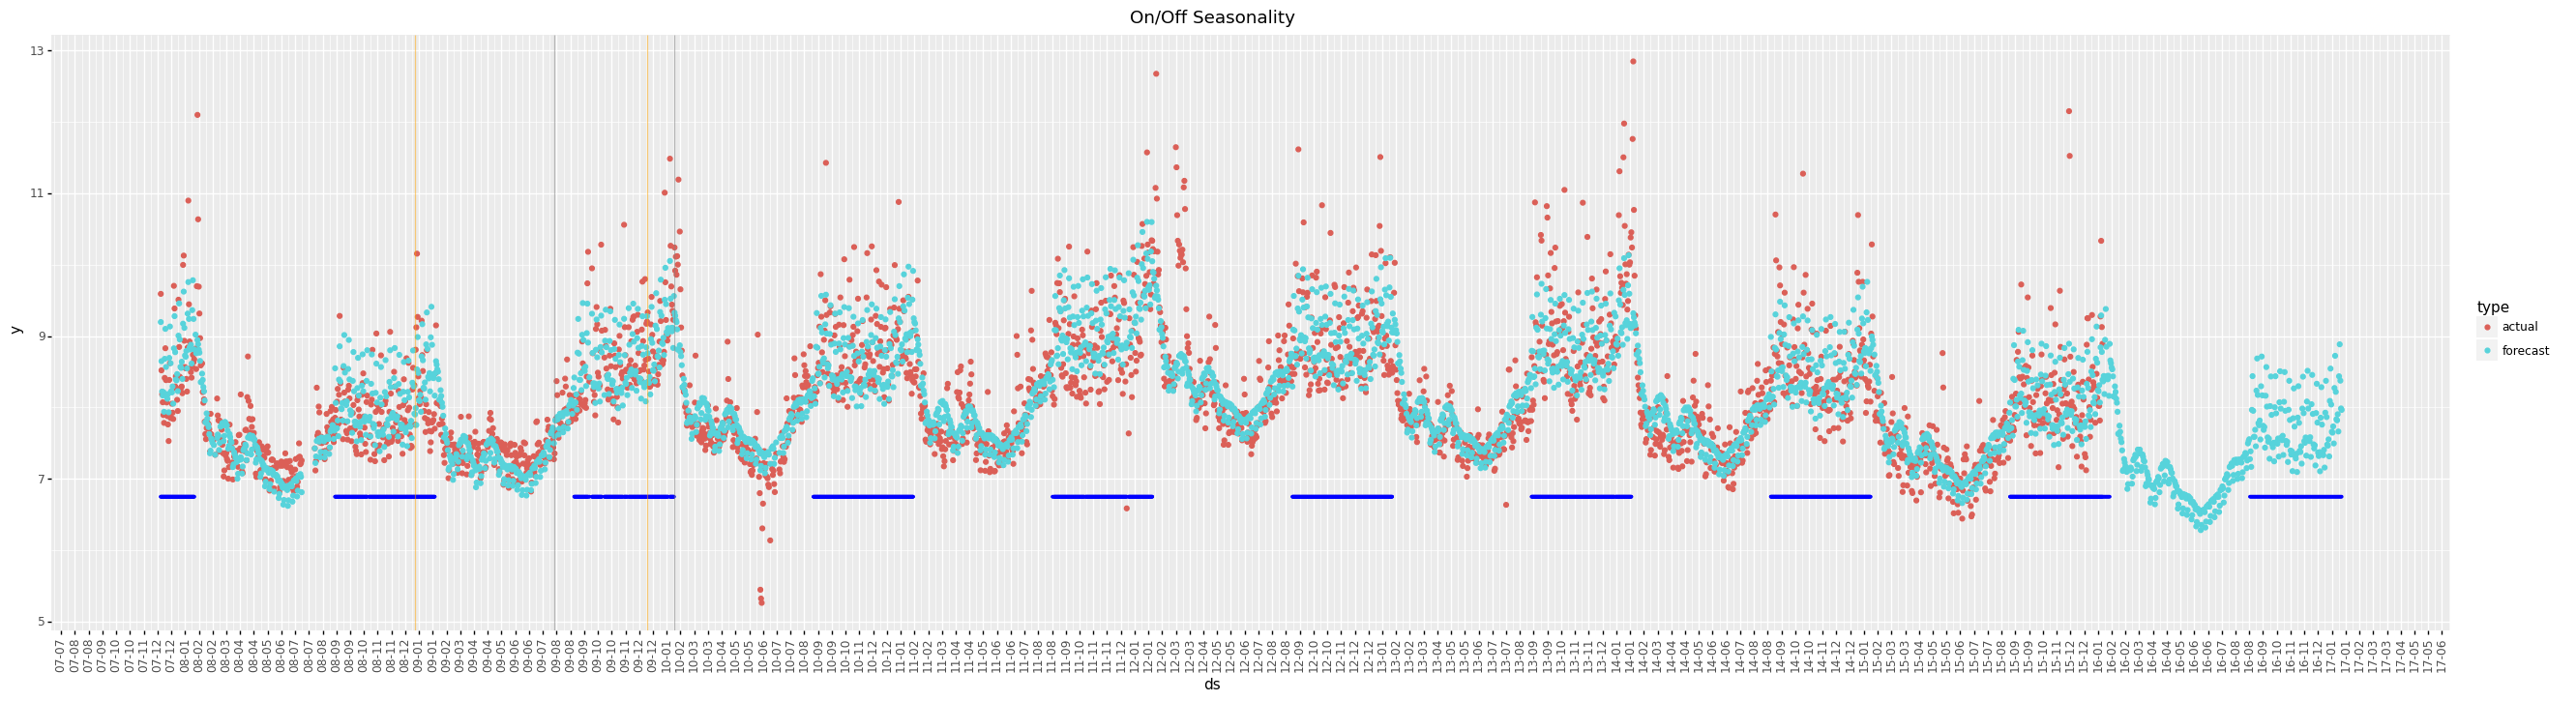

<ggplot: (8766108206324)>


In [315]:
## Viz
print(
    ggplot(forecast_addsea_review,aes('ds','y',color='type'))
    +geom_point()
    +geom_point(forecast_addsea_review.loc[forecast_addsea_review.on_season==True,:],
               aes('ds','y2'),color='blue',size=0.5)
    +scale_x_datetime(date_breaks='21 days',date_labels='%y-%m')
    +geom_vline(xintercept=[pd.to_datetime('2009-08-01'),
                            pd.to_datetime('2010-02-01')
                           ],color='grey',alpha=0.5)
    +geom_vline(xintercept=[pd.to_datetime('2009-01-01'),
                            pd.to_datetime('2009-12-21')
                           ],color='orange',alpha=0.5)
    +theme(axis_text_x=element_text(angle=90),figure_size=(32,8))
    +labs(title='On/Off Seasonality')
)

/home/ubuntu/anaconda3/lib/python3.8/site-packages/plotnine/stats/smoothers.py:310: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.


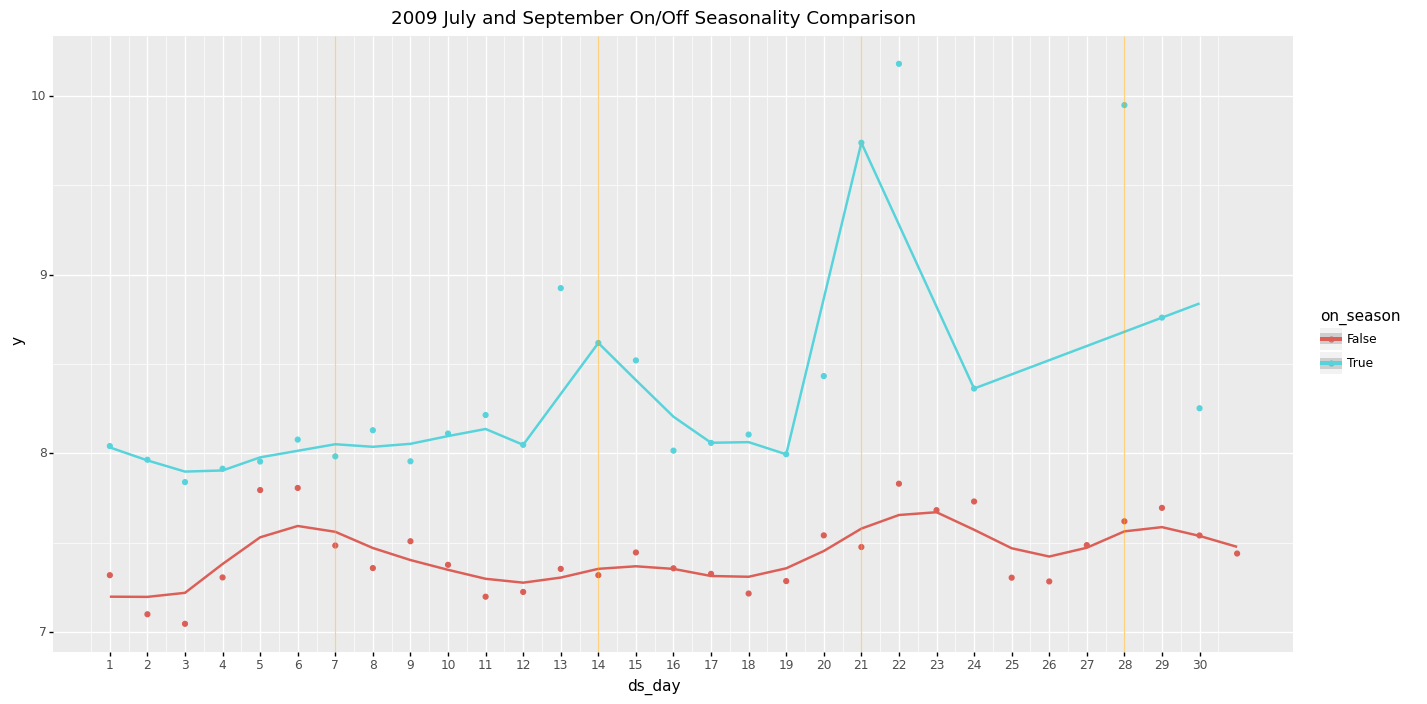

<ggplot: (8766108519656)>


In [316]:
## Viz - specific month comparison
print(
    ggplot(forecast_addsea_review.loc[(forecast_addsea_review.type=='actual')&
                                      (forecast_addsea_review.ds.dt.year==2009)&
                                      (forecast_addsea_review.ds.dt.month.isin([7,9])),
                                      :].assign(ds_day=lambda x:x.ds.dt.day),
           aes('ds_day','y',color='on_season'))
    +geom_point()
    +geom_smooth(span=0.2)
    +scale_x_continuous(breaks=np.arange(1,31,1))
    +geom_vline(xintercept=[7,14,21,28],color='orange',alpha=0.5)
    #+geom_line(forecast_addsea_review.loc[(forecast_addsea_review.on_season==True)&
    #                                      (forecast_addsea_review.ds.dt.year==2008)&
    #                                      (forecast_addsea_review.ds.dt.month.isin([6,7])),:],
    #           aes('ds','y2'),color='blue')
    #+scale_x_datetime(date_breaks='1 days',date_labels='%y-%m')
    +theme(figure_size=(16,8))
    +labs(title='2009 July and September On/Off Seasonality Comparison')
)

# 06 Prior Scale for Holidays and Seasonality

## 06.1 Configuring 

In [318]:
m_priorscale=Prophet(holidays=holiday,
                     holidays_prior_scale=0.05 # default =10
                    ).fit(df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


## 06.2 Predicting

In [319]:
forecast_prior_scale=m_priorscale.predict(future)